# Abstrakt


# Cel projektu

Celem projektu było stworzenie liniowego modelu ilości wpadków na drogach z pomocą zmiennych objaśniających pobranych ze strony policji oraz na podstawie pogody.

# Dane

Dane pochodzą ze strony policji, obejmują zakres pierwszego kwartału roku 2020. Więcej o nich można znaleźć tutaj: [Strona policji](https://policja.pl/pol/form/1,dok.html)

Drugi zestaw danych to dane meteorologiczne dla Warszawy, również z pierwszego kwartału roku 2020. Pobrane zostały z pomocą API platrofmy www.meteostat.net/

## Pobranie danych

In [17]:
import pandas
import numpy as np

In [9]:
df = pandas.read_csv("./dane.csv", sep="\t", decimal=",", dtype="float32")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Wypadki drogowe                  60 non-null     float32
 1   Zatrzymani poszukiwani           60 non-null     float32
 2   Zatrzymani nietrzeźwi kierujący  60 non-null     float32
 3   temperature_max                  60 non-null     float32
 4   mobilność pojazdów               60 non-null     float32
 5   Zabici w wypadkach               60 non-null     float32
 6   Ranni w wypadkach                60 non-null     float32
 7   temperature                      60 non-null     float32
 8   temperature_min                  60 non-null     float32
 9   Interwencje                      60 non-null     float32
 10  Zatrzymani na gorącym uczynku    60 non-null     float32
dtypes: float32(11)
memory usage: 2.7 KB


Jak widać powyżej dane składają się z 60 próbek oraz nie posiadają pustych wartości.

## Eliminacja quasi - stalych

In [28]:
S = df.var()
x = df.mean()

In [29]:
S / x

Wypadki drogowe                      5.019958
Zatrzymani poszukiwani              16.410904
Zatrzymani nietrzeźwi kierujący     13.943410
temperature_max                      1.059987
mobilność pojazdów                 -13.597410
Zabici w wypadkach                   1.414983
Ranni w wypadkach                    6.134233
temperature                          1.120702
temperature_min                      2.801074
Interwencje                        234.719513
Zatrzymani na gorącym uczynku       24.527481
dtype: float32

Ze względu na małą zmienność (5%) wartości przewydywanej (wypadki drogowe). W modelu uwzględnię wszystkie zmienne, kóre mają zmienność większą.

Index(['Wypadki drogowe', 'Zatrzymani poszukiwani',
       'Zatrzymani nietrzeźwi kierujący', 'mobilność pojazdów',
       'Ranni w wypadkach', 'Interwencje', 'Zatrzymani na gorącym uczynku'],
      dtype='object')

In [32]:
df = df[df.columns[np.abs((S / x)) > 5]]

In [34]:
df.head(5)

,Wypadki drogowe,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,mobilność pojazdów,Ranni w wypadkach,Interwencje,Zatrzymani na gorącym uczynku
0,31.0,126.0,106.0,-62.619999,30.0,11688.0,255.0
1,17.0,139.0,104.0,-63.669998,27.0,13228.0,301.0
2,29.0,151.0,94.0,-64.220001,32.0,13966.0,296.0
3,24.0,153.0,114.0,-63.400002,20.0,15926.0,285.0
4,30.0,151.0,145.0,-70.489998,33.0,18900.0,383.0


# Wybór zmiennych do modelu

Wybierając zmienne w modelu, posłużę się metodą analizy macierzy współczynników korelacji.

In [74]:
from scipy.stats import t

alpha = 0.05
N = len(df)
t = t.ppf(1 - alpha, N-2)

In [75]:
r = np.sqrt(t**2/(t**2 + N - 2))
r

0.2143825406137366

In [76]:
df.corr()

,Wypadki drogowe,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,mobilność pojazdów,Ranni w wypadkach,Interwencje,Zatrzymani na gorącym uczynku
Wypadki drogowe,1.000000,0.507234,0.429340,0.767076,0.960340,0.379193,0.690641
Zatrzymani poszukiwani,0.507234,1.000000,-0.134454,0.723037,0.492617,0.192777,0.462056
Zatrzymani nietrzeźwi kierujący,0.429340,-0.134454,1.000000,0.401068,0.415218,0.120871,0.750261
mobilność pojazdów,0.767076,0.723037,0.401068,1.000000,0.751973,0.086337,0.831563
Ranni w wypadkach,0.960340,0.492617,0.415218,0.751973,1.000000,0.292307,0.680938
Interwencje,0.379193,0.192777,0.120871,0.086337,0.292307,1.000000,0.154223
Zatrzymani na gorącym uczynku,0.690641,0.462056,0.750261,0.831563,0.680938,0.154223,1.000000


1. Usuwam zmienne, dla których wartość w kolumnie `Wypadki drogowe` jest poniżej progu `r` (tutaj wszystkie są OK).

In [78]:
df.corr().loc["Ranni w wypadkach"]

Wypadki drogowe                    0.960340
Zatrzymani poszukiwani             0.492617
Zatrzymani nietrzeźwi kierujący    0.415218
mobilność pojazdów                 0.751973
Ranni w wypadkach                  1.000000
Interwencje                        0.292307
Zatrzymani na gorącym uczynku      0.680938
Name: Ranni w wypadkach, dtype: float64

2. Wybieram `Ranni w wypadkach`. Usuwam `Zatrzymani poszukiwani`, `Zatrzymani nietrzeźwi kierujący`, `mobilność pojazdów`, `Interwencje` ,`Zatrzymani na gorącym uczynku`, 
3. Koniec.

# Budowa modelu
## Model 1

In [121]:
import statsmodels.api as sm

y = df['Wypadki drogowe']
X = df[['Ranni w wypadkach']]
X = sm.add_constant(X) # Dodaję stałą do modelu

In [122]:
model = sm.OLS(y, X)

In [123]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Wypadki drogowe   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     688.0
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           7.33e-34
Time:                        11:22:33   Log-Likelihood:                -170.65
No. Observations:                  60   AIC:                             345.3
Df Residuals:                      58   BIC:                             349.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.6426      1.67

Model ma:
- [x] R-squared powyżej 0.8
- [x] Adj. R-squared powyżej 0.8
- [x] Prob (F-statistic) < 0.05
- [x] p value dla każdej ze zmiennych < 0.05
- [x] Prob(Omnibus) > 0.05 (test normalności reszt, H_0: rozkład normalny)
- [x] Prob(JB) > 0.05

Zatem model przeszedł wszystkie testy statystyczne.

### Analiza reszt

In [124]:
import seaborn as sns

Text(0.5, 1.0, 'Histogram reszt modelu')

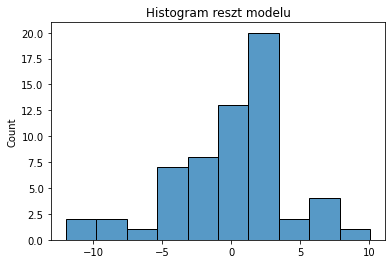

In [128]:
sns.histplot(results.resid).set_title('Histogram reszt modelu')

Jak widać na wykresie, reszty te przypominają rozkład normalny, ale cechują się przechyleniem w prawo.

In [137]:
# Test normalności rozkładu rest
from scipy.stats import normaltest
normaltest(results.resid)

NormaltestResult(statistic=5.317197038474779, pvalue=0.0700463215582532)

In [138]:
# Test serii
from statsmodels.sandbox.stats.runs import runstest_1samp 
z_statistic, pvalue = runstest_1samp(results.resid)
print("Test serii")
print(f"Wartość statystyki: {z_statistic}")
print(f"Pvalue : {pvalue}")

Test serii
Wartość statystyki: -0.38897672411182915
Pvalue : 0.697293364649107


### Wykresy 

In [139]:
import matplotlib.pylab as plt

In [151]:
x

Wypadki drogowe                       45.066666
Zatrzymani poszukiwani               199.050003
Zatrzymani nietrzeźwi kierujący      172.350006
temperature_max                       16.174999
mobilność pojazdów                   -37.415001
Zabici w wypadkach                     4.683333
Ranni w wypadkach                     50.450001
temperature                           10.536668
temperature_min                        4.040000
Interwencje                        15881.983398
Zatrzymani na gorącym uczynku        487.683319
dtype: float32

Text(0.5, 1.0, 'Wykres przewidywań modelu')

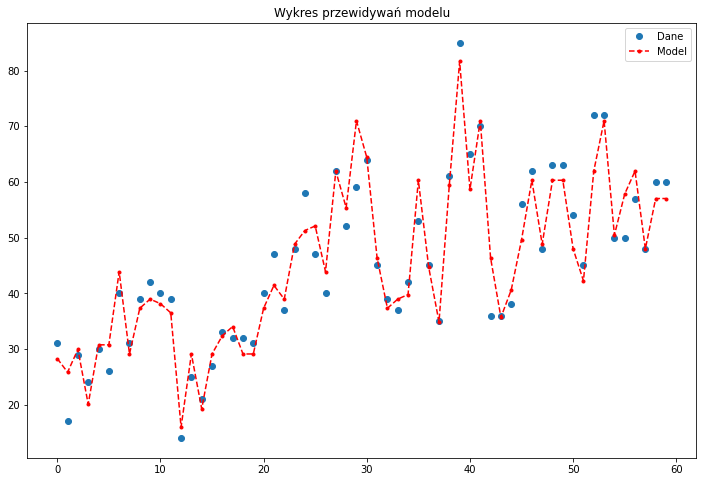

In [179]:
pred_ols = results.get_prediction()
x = df.index
y_true = df['Wypadki drogowe']
y = df['Wypadki drogowe'] * 0.8211 + 3.6426

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(y_true, "o", label="Dane")
ax.plot(results.fittedvalues, "r--.", label="Model")
ax.legend(loc="best")
ax.set_title("Wykres przewidywań modelu")